In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn
import sys
sys.path.append("..")
import model.simplenet as simplenet
import matplotlib.pyplot as plt
import imageio
import torch.nn.functional as F
import numpy as np
import random
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def change_weight(weight):
    '''
    Change the weight matrix in quadratic neural network.
    '''
    model_dict = model.state_dict()
    model_dict['classifier.0.weight_a'] = weight
    model.load_state_dict(model_dict)
    
    return

def matshow(a):
    m = torch.max(abs(a))
    plt.figure()    
    plt.matshow(a.reshape(28,28),cmap=plt.cm.gray,vmin = -m,vmax = m)
    plt.colorbar()
    return

def savefig(name):
    plt.savefig(name,dpi=600, bbox_inches='tight')
    return

def change_eigen(eigen):

    model_dict = model.state_dict()
    model_dict['classifier.0.eigen'] = eigen
    model.load_state_dict(model_dict)

    return

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.benchmark = True #for accelerating the running
    return


def intermediate_output(x, k):
    for i in range(k):
        x = model[i](x)
    return x
    

def intermediate_output(x, k, feature_layer=2):
    with torch.no_grad():
        for i in range(k):
            if i < feature_layer:
                x = model.features[i](x)
            else:
                x = x.view(x.size(0), -1)
                x = model.classifier[i-feature_layer](x)
    return x

setup_seed(2)


#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
valid_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, transform=transforms.ToTensor())

#FMNIST dataset
#train_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
#valid_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, transform=transforms.ToTensor())


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
all_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000)
#EI_distribution = torch.bernoulli(torch.ones(784)*0.75)
#kappa_matrix = -torch.ones(784, 784)
#kappa_matrix[EI_distribution==0,:] = 1
#kappa_matrix[:,EI_distribution==0] = 1

model = simplenet.SimpleNet_2(num_eigens=1)
#model = nn.DataParallel(model, device_ids=[0]).cuda()
#model = nn.DataParallel(model, device_ids=[0])
print(model)
#initial_weight_a = model.state_dict()['classifier.0.weight_a']
#change_weight(torch.zeros(10,784,784))
#torch.save(initial_weight_a,'initial_weight_a')
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
test_accuracy = []
train_accuracy = []
all_loss = []
all_train_loss = []
best_prec = 0
min_loss = 1
image_list = []
KS_dis = []
number = 0
difference = []
mean = []
#model_dict = model.state_dict()
#model_dict['module.features.0.weight'] = torch.load('convolution_kernel')
#model.load_state_dict(model_dict)
#out = torch.zeros(240,10,10)
#inner_product = torch.zeros(240,10,10)
#s = torch.zeros(240,10,10)
#phi = torch.zeros(240,10,784)
for epoch in range(0, 2):
    lr = 0.01
    #else:
     #   lr = 0.0001

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    model.train()

    # train for one epoch
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input, target = input, target.long()
        train_total = 0
        train_correct = 0
        train_loss = 0
        # compute output
        output = model(input)
        loss = criterion(output, target)
       

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        ave_loss = train_loss/(i+1)

        _, predicted = torch.max(output.data, 1)
        train_total = target.size(0)
        train_correct = (predicted == target).sum().item()

        prec = train_correct / train_total

        #eigen = model.state_dict()['classifier.0.eigen']
        
        #for j in range(10):
         #   new_eigen[j,:,:] = eigen[j,:,:]/torch.norm(eigen[j,:,:],2)
        #change_eigen(new_eigen)

        #model_dict = model.state_dict()
        #model_dict['module.features.0.weight'] = torch.load('convolution_kernel')
        #model.load_state_dict(model_dict)

        #weight_a = model.state_dict()['classifier.0.weight_a']
        #for j in range(10):
         #   new_weight[j,:,:] = weight_a[j,:,:]/torch.norm(weight_a[j,:,:],'fro')
        #change_weight(new_weight)
        
        if i % 5 == 0:
            train_accuracy.append(prec)
            all_train_loss.append(loss)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.5f}, Train_Acc:{:.2f}%'.format(epoch+1, 20, i, len(train_loader), ave_loss, prec*100))
            
            
    # evaluate on test set
    # switch to evaluate mode
            #convolution_kernel = model.state_dict()['module.features.0.weight']
            model.eval()
            valid_correct = 0
            valid_total = 0
            with torch.no_grad():
                total_loss = 0
                for j, (input, target) in enumerate(valid_loader):
                    input, target = input, target.long()
                    # compute output
                    output = model(input)
                    loss = criterion(output, target)

                    #for digit in range(10):
                     #   for index in range(output.shape[0]):
                      #      if target[index] == digit:
                       #         out[number,:,digit] += output[index,:]#/((torch.norm(eigen[digit,:,:],2)*torch.norm(output_first_layer_after[index,:],2))**2)
                        #        inner_product[number,:,digit] += torch.mm(eigen[:,:,0],output_first_layer_after[index,:].reshape(784,1)).reshape(10)
                         #       s[number,:,digit] += F.softmax(output[index,:],dim=0)
                        #out[number,:,digit] = out[number,:,digit]/1000
                        #inner_product[number,:,digit] = inner_product[number,:,digit]/1000
                        #s[number,:,digit] = s[number,:,digit]/1000
                        #phi[number,digit,:] = torch.sum(output_first_layer_after[target==digit,:], dim=0)/1000
                    #number += 1

                    _, predicted = torch.max(output.data, 1)
                    valid_total = output.shape[0]
                    valid_correct = (predicted == target).sum().item()
                    prec = valid_correct / valid_total
                    print('Accuary on test images:{:.2f}%, loss:{:.2f}'.format(prec*100,loss))
                    test_accuracy.append(prec)
                    all_loss.append(loss)
                    best_prec = max(prec, best_prec)

                for j, (input, target) in enumerate(all_train_loader):
                    input, target = input, target.long()
                    output = model(input)

                    mean_difference = 0
                    for index in range(output.shape[0]):
                        output[index,:] = output[index,:]/torch.norm(output[index,:],2)
                        #all_cos_cor[index] = output[index, target[index]]
                        #all_cos_mis[:,index] = output[index, torch.arange(10) != target[index]]
                        for digit in range(10):
                            if digit != target[index]:
                                mean_difference += output[index, target[index]]-output[index,digit]

                    mean.append(mean_difference/540000)

                #all_cos_cor = torch.zeros(output.shape[0])
                #all_cos_mis = torch.zeros(9,output.shape[0])  
                        
                #for index in range(output.shape[0]):
                 #   output[index,:] = output[index,:]/torch.norm(output[index,:],2)
                  #  all_cos_cor[index] = output[index, target[index]]
                   # all_cos_mis[:,index] = output[index, torch.arange(10) != target[index]]

                #bins=np.arange(min(torch.min(all_cos_cor), torch.min(all_cos_mis)),max(torch.max(all_cos_cor), torch.max(all_cos_mis)), 1/2000) 
                #frequency_each,_ = np.histogram(all_cos_mis.reshape(9*output.shape[0]).tolist(), bins = bins)
                #frequency_each_c,_ = np.histogram(all_cos_cor.tolist(),bins = bins)
                #cdf_mistaken = torch.cat((torch.Tensor([0]),torch.cumsum(torch.from_numpy(frequency_each)/(9*output.shape[0]), dim=0)),0)
                #cdf_correct = torch.cat((torch.Tensor([0]),torch.cumsum(torch.from_numpy(frequency_each_c)/output.shape[0], dim=0)),0)
                #KS_distance = torch.max(abs(cdf_correct-cdf_mistaken))
                #KS_dis.append(KS_distance)
                            


                

print('Best accuracy is: {:.2f}%'.format(best_prec*100))
#weight_a = model.state_dict()['classifier.0.weight_a']
#torch.save(weight_a,'afte r_train_weight')
#torch.save(weight_a,'weight_a')
# 改变模型参数
#model_dict = model.state_dict()
#model_dict['module.classifier.0.weight_a'] = torch.zeros(10,784,784)
#model.load_state_dict(model_dict)

SimpleNet_2(
  (features): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Low_dimensional_quadratic(in_features=784, out_features=10, number_eigens=1, bias=False)
  )
)
Epoch [1/20], Step [0/600], Loss: 2.30253, Train_Acc:15.00%
Accuary on test images:11.17%, loss:2.30
Epoch [1/20], Step [5/600], Loss: 0.38375, Train_Acc:19.00%
Accuary on test images:11.89%, loss:2.30
Epoch [1/20], Step [10/600], Loss: 0.20933, Train_Acc:8.00%
Accuary on test images:12.51%, loss:2.30
Epoch [1/20], Step [15/600], Loss: 0.14391, Train_Acc:14.00%
Accuary on test images:13.10%, loss:2.30
Epoch [1/20], Step [20/600], Loss: 0.10965, Train_Acc:10.00%
Accuary on test images:13.57%, loss:2.30
Epoch [1/20], Step [25/600], Loss: 0.08856, Train_Acc:17.00%
Accuary on test images:14.30%, loss:2.30
Epoch [1/20], Step [30/600], Loss: 0.07427, Train_Acc:19.00%
Accuary on test images:14.82%, loss:2.30
Epoch [1/20],

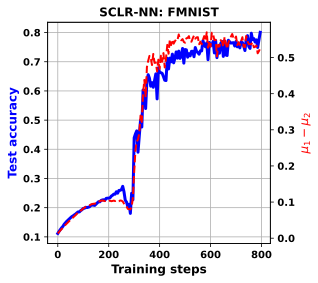

In [8]:
test_accuracy = torch.Tensor(test_accuracy)
mean = torch.Tensor(mean).cpu()

#for digit in range(10):

plt.figure(figsize=(4,4)) 
ax1 = plt.subplot(111)

plt.xticks(weight = 'bold')
ax1.plot(5*torch.arange(len(test_accuracy))[:160], test_accuracy[:160] ,color = 'blue',linewidth = 3)
plt.yticks(weight = 'bold')
ax2 = ax1.twinx()
ax2.plot(5*torch.arange(len(test_accuracy))[:160], mean[:160],color = 'red',linewidth = 2,linestyle = '--')
ax1.set_xlabel("Training steps",fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('$\mu_1-\mu_2$',fontsize = 12, color = 'red', fontweight = 'bold')
ax1.set_ylabel('Test accuracy',fontsize = 12, color = 'blue', fontweight = 'bold')
plt.yticks(weight = 'bold')
plt.title('SCLR-NN: FMNIST', fontsize = 12, fontweight = 'bold')
ax1.grid()
savefig('md_sclrnnfmnist.pdf')

# Adversarial example

In [9]:
def generate_adversial_exm_grad(varepsilon):
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input, target.long()
        adversial_exm = input
        
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=1)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input, target.long()

        input.requires_grad = True
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
    
        adversial_exm[i:i+1,:,:,:] = input + varepsilon*input.grad/torch.norm(input.grad)
        
        
    adversial_exm = adversial_exm.detach()
    return adversial_exm.data


def generate_adversial_exm_sign(varepsilon):
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input, target.long()
        adversial_exm = input
        
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=1)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input, target.long()

        input.requires_grad = True
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
    
        adversial_exm[i:i+1,:,:,:] = input + varepsilon*torch.sign(input.grad)
        
        
    adversial_exm = adversial_exm.detach()
    return adversial_exm.data

for j, (input, target) in enumerate(valid_loader):
    input, target = input, target.long()

test_accuracy = torch.zeros(10)
adversial_input_all = torch.zeros(10,10000,784)
for j in range(10):
    varepsilon = 0.01*j
    #adversial_input = generate_adversial_exm_grad(varepsilon)
    adversial_input_1 = generate_adversial_exm_sign(varepsilon)
    adversial_input_all[j,:,:] = adversial_input_1.reshape(10000,784)

    model.eval()
#valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
#for i, input in enumerate(valid_loader):
 #   input = input

#valid_correct = 0
#valid_total = 0
#with torch.no_grad():
 #   output = model(adversial_input)

   # _, predicted = torch.max(output.data, 1)
    #valid_total = target.size(0)
    #valid_correct = (predicted == target).sum().item()



#prec = valid_correct / valid_total
#print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec*100, j*0.1))

    valid_correct = 0
    valid_total = 0
    with torch.no_grad(): 
        output = model(adversial_input_1)

        _, predicted = torch.max(output.data, 1)
        valid_total = target.size(0)
        valid_correct = (predicted == target).sum().item()


    prec_1 = valid_correct / valid_total
    print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec_1*100, varepsilon))

#input = input.reshape(10000,512)
#difference = torch.cat([difference,torch.zeros(10000,1)],dim=1)
    test_accuracy[j] = prec_1 #gradient ad
#test_accuracy[1,j] = prec_1 #sign ad

Accuary on test images:83.64%, epsilon:0.0
Accuary on test images:4.19%, epsilon:0.1


In [3]:
for j, (input, target) in enumerate(valid_loader):
    input, target = input, target.long()

test_accuracy = torch.zeros(10)
for j in range(10):
#adversial_input = generate_adversial_exm_grad(0.5)
    adversial_input_1 = torch.load('ad_all_fmnist_gradient')[j,:,:].reshape(10000,1,28,28)

    model.eval()
#valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
#for i, input in enumerate(valid_loader):
 #   input = input

#valid_correct = 0
#valid_total = 0
#with torch.no_grad():
 #   output = model(adversial_input)

   # _, predicted = torch.max(output.data, 1)
    #valid_total = target.size(0)
    #valid_correct = (predicted == target).sum().item()



#prec = valid_correct / valid_total 
#print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec*100, j*0.1))

    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        output = model(adversial_input_1)

        _, predicted = torch.max(output.data, 1)
        valid_total = target.size(0)
        valid_correct = (predicted == target).sum().item()


    prec_1 = valid_correct / valid_total
    print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec_1*100, j*0.01))
    test_accuracy[j] = prec_1

torch.save(test_accuracy, 'ad_gradient_quadratic_fmnist')

Accuary on test images:88.68%, epsilon:0.0
Accuary on test images:84.23%, epsilon:0.01
Accuary on test images:78.61%, epsilon:0.02
Accuary on test images:71.69%, epsilon:0.03
Accuary on test images:63.44%, epsilon:0.04
Accuary on test images:55.53%, epsilon:0.05
Accuary on test images:47.72%, epsilon:0.06
Accuary on test images:40.06%, epsilon:0.07
Accuary on test images:33.34%, epsilon:0.08
Accuary on test images:27.42%, epsilon:0.09


In [13]:
digit = 9
for j, (input, target) in enumerate(valid_loader):
    input, target = input, target.long()
feature_map = intermediate_output(input, 2)
feature_map_digit = feature_map[target==digit,:].reshape(sum(target==digit),784)
with torch.no_grad():
    u,s,v = torch.svd(feature_map_digit-torch.mean(feature_map.reshape(10000,784), dim=0))
    plt.figure(figsize=(4,4))
    plt.bar(torch.arange(30),s[:30]/max(s), color = 'orange')
    plt.title('Class {}'.format(digit), fontsize=12)
    plt.xlabel('Index of eigens', fontsize=15)
    plt.ylabel('Eigenvalue $\lambda/\lambda_{\max}$',fontsize=15)
    plt.ylim([0,1.1])
    savefig('fmnist_feature_similarity_{}.pdf'.format(digit))

In [ ]:
out = inner_product

for digit in range(10):
    plt.figure(figsize=(17.5,15.7))
    plt.title('Class {}'.format(digit),fontsize=20)
    for svg in range(9):
    #fig,ax = plt.subplots(1, 1)
    #plt.scatter(out[60:,0,digit],out[60:,1,digit],c=np.arange(180),cmap=plt.cm.Purples,s=100)
    #cb_1 = plt.colorbar()
    #cb_1.set_label('last 180 steps')
        plt.subplot(331+svg)
        plt.scatter(out[:,digit,digit],out[:,digit,torch.arange(10)[torch.arange(10)!=digit][svg]],c=np.arange(240),cmap=plt.cm.YlOrBr,s=100)
        #cb = plt.colorbar()
        #cb.set_label('training steps',fontsize=15)
        plt.scatter(out[30,digit,digit],out[30,digit,torch.arange(10)[torch.arange(10)!=digit][svg]],c='red',s=100,label='loss converge point')
        #axins = ax.inset_axes((0, 8, 5, 8))
        #axins.plot(torch.arange(240),x_norm,color='black',linestyle='--',linewidth=3)
        #axins.grid()
        #axins.set_xlabel('Training steps')
        #axins.set_ylabel('$\|\hat{{x}}\|$')
        #plt.scatter(out_1[:,0],out_1[:,1],c=np.arange(120),cmap=plt.cm.GnBu,s=100)
        #plt.plot(x,y,linestyle='--',linewidth=3,label='Unit Circle')
        plt.grid()
        plt.legend(loc='best')
        plt.xlabel('Target output ($a_{{{},{}}}$)'.format(digit,digit))
        plt.ylabel('Other output ($a_{{{},{}}}$)'.format(digit,torch.arange(10)[torch.arange(10)!=digit][svg]))
    #savefig('batch_output_relation_{}.svg'.format(digit))
    plt.show()

In [ ]:
test_accuracy = torch.Tensor(test_accuracy)
KS_dis = torch.Tensor(KS_dis)

for digit in range(10):
    fig = plt.figure() 
    ax1 = fig.add_subplot(111)

    ax1.plot(torch.arange(300), torch.Tensor(test_accuracy[torch.arange(3000)%10==digit]) ,color = 'blue',linewidth = 5)
    ax2 = ax1.twinx()
    ax2.plot(torch.arange(300), torch.Tensor(KS_dis[torch.arange(3000)%10==digit]) ,color = 'red',linewidth = 3,linestyle = '--')
    ax1.set_xlabel("Training step",fontsize = 20)
    ax2.set_ylabel('KS distance',fontsize = 20, color = 'red')
    ax1.set_ylabel('Test Accuracy',fontsize = 20, color = 'blue')
    plt.title('Class {}'.format(digit), fontsize = 20)
    savefig('linear_KS_fmnist_two_norm_{}.svg'.format(digit))

In [ ]:
# Quadratic recognize the feature map of different class, spike trigger average
for i, (input, target) in enumerate(valid_loader):
    input, target = input.cuda(), target.long().cuda()
    
convolution_kernel = model.state_dict()['module.features.0.weight']
output_first_layer = F.conv2d(input, convolution_kernel.cuda(), padding=2).reshape(10000,784)
spike_trigger_average = torch.zeros(784).cuda()
picture_label = 9
k = 0
#obtain input
input = input.reshape(10000,784)
#output = model(input)

for i in range(10000):
    if target[i] == picture_label:
        spike_trigger_average += output_first_layer[i,:]
        k = k+1
spike_trigger_average = spike_trigger_average/k 
matshow(spike_trigger_average.cpu())